In [69]:
import numpy as np
from functions import *
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import unitary_group

In [175]:
def qEntropy(rho):
    return -np.real(np.trace(rho @ sp.linalg.logm(rho)))


def qfreeEnergy(T, H, rho):
    return np.real(np.trace(rho @ H)) - T * qEntropy(rho)

In [134]:
def energy(H, rho):
    return np.trace(rho @ H).real

def variance(H, rho):
    return np.trace(rho @ (H @ H)).real - np.trace(rho @ H).real**2

def a(s, H, V):
    return H/(np.sqrt(V))*np.sin(s*np.sqrt(V)) + np.cos(s*np.sqrt(V))

def b(s, V):
    return -1/(np.sqrt(V))*np.sin(s*np.sqrt(V))

def betaPrime(beta, rho, s, E, H):
    Hexp = energy(H, rho)
    V = variance(H, rho)
    aCoeff = a(s, Hexp, V)
    bCoeff = b(s, V)
    return beta - np.log((1+bCoeff*E/aCoeff)**2)/E

def ZPrime1(Z, rho, H, s):
    Hexp = energy(H, rho)
    V = variance(H, rho)
    aCoeff = a(s, Hexp, V)
    return Z/aCoeff**2

def ZPrime2(Z, beta, rho, H, s, E):
    Hexp = energy(H, rho)
    V = variance(H, rho)
    aCoeff = a(s, Hexp, V)
    bCoeff = b(s, V)
    betaP = betaPrime(beta, rho, s, E, H)
    return Z*np.exp(-E*(betaP-beta))/(aCoeff+bCoeff*E)**2

def dbi(state, H, s):
    rho = np.outer(state, state.conj())
    W = commutator(rho, H)
    return sp.linalg.expm(s*W) @ state

def partial_trace(rho, nqubits, keep=0):

    d = 2 ** (nqubits // 2)  # Dimension of each subsystem
    rho = rho.reshape([d, d, d, d])  # Reshape into a 4D tensor

    if keep == 0:  # Trace out the second subsystem (B)
        return np.trace(rho, axis1=1, axis2=3)  # Partial trace over B
    else:  # Trace out the first subsystem (A)
        return np.trace(rho, axis1=0, axis2=2)  # Partial trace over A

In [ ]:
nqubits = 4
beta = 0.1
H_def = sum([-Z(x)*Z(x+1) + X(x) for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
energies = np.linalg.eigvals(H)
H = H - np.min(energies)*np.eye(2**nqubits)
energies = np.linalg.eigvals(H)
print(energies)
thermalState = np.diag(np.exp(-beta*energies))
partition = np.trace(thermalState)
rho = thermalState/partition
Zp1 = ZPrime1(partition, rho, H, 1.0)
Zp2 = ZPrime2(partition, beta, rho, H, 1.0, energies[7])
print(Zp1, Zp2)



[Qibo 0.2.16|WARNING|2025-05-05 16:25:40]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[2.85144430e-15+0.j 8.05467898e+00+0.j 8.05467898e+00+0.j
 3.75779810e-15+0.j 1.53073373e+00+0.j 2.82842712e+00+0.j
 1.53073373e+00+0.j 6.52394525e+00+0.j 6.52394525e+00+0.j
 5.22625186e+00+0.j 5.22625186e+00+0.j 2.82842712e+00+0.j
 4.35916085e+00+0.j 4.35916085e+00+0.j 3.69551813e+00+0.j
 3.69551813e+00+0.j]
(382.3500799173945+0j) (382.350079917395+0j)


[Qibo 0.2.16|WARNING|2025-05-07 12:39:45]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
C:\Users\andre\AppData\Local\Temp\ipykernel_14324\2309516123.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  freeEnergy[s] = (qfreeEnergy(1/betaP[s], HA, rhoA))


[-3.53702738e-16  2.82842712e+00  2.82842712e+00  5.65685425e+00]


Text(0, 0.5, "$\\beta '$")

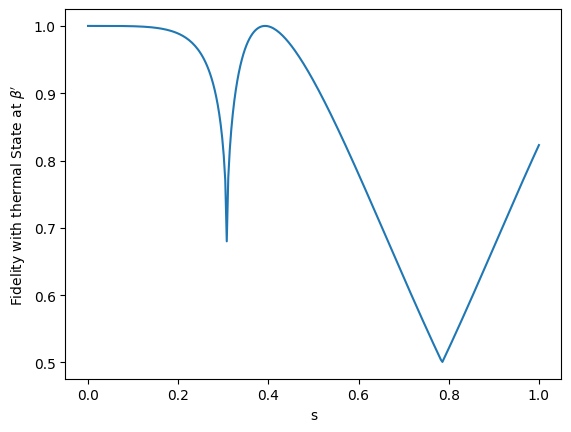

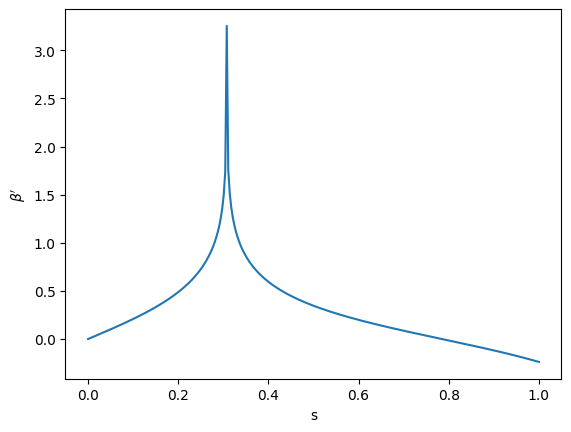

In [201]:
nqubits = 2
beta = 0.0
H_def = sum([-Z(x) + X(x) for x in range(nqubits)])
HA = hamiltonians.SymbolicHamiltonian(H_def).matrix
energies = np.linalg.eigvalsh(HA)
HA = HA - np.min(energies)*np.eye(2**nqubits)
energies = np.linalg.eigvalsh(HA)
print(energies)
H = np.kron(HA, np.eye(2**nqubits))
step = np.linspace(0.00, 1, 300)
betaP = np.zeros(len(step))
fidelity = np.zeros(len(step))
initState = tfd0(nqubits)
freeEnergy = np.zeros(len(step))
rhoInit = np.outer(initState, initState.conj())
for s in range(len(step)):
    
    betaP[s] = betaPrime(beta, rhoInit, step[s], energies[-1], H)
    dbiState = dbi(initState, H, step[s])
    rho = np.outer(dbiState, dbiState.conj())
    rhoA = partial_trace(rho, nqubits*2, 0)
    freeEnergy[s] = (qfreeEnergy(1/betaP[s], HA, rhoA))
    newThermalState = sp.linalg.expm(-betaP[s]*HA) / np.trace(sp.linalg.expm(-betaP[s]*HA))
    fidelity[s] = np.real(np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rhoA)@newThermalState@sp.linalg.sqrtm(rhoA)))**2)

plt.figure()
plt.plot(step, fidelity)
plt.xlabel("s")
plt.ylabel(r"Fidelity with thermal State at $\beta '$")

plt.figure()
plt.plot(step, betaP)
plt.xlabel("s")
plt.ylabel(r"$\beta '$")



[Qibo 0.2.16|WARNING|2025-05-07 13:37:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[-2.49262846e-16  2.82842712e+00  2.82842712e+00  2.82842712e+00
  5.65685425e+00  5.65685425e+00  5.65685425e+00  8.48528137e+00]


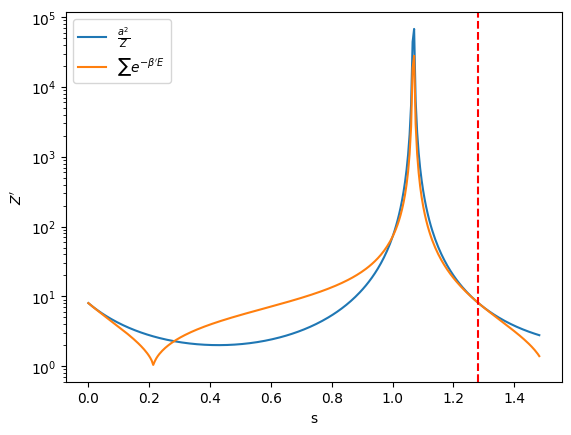

In [245]:
nqubits = 3
beta = 0.0
H_def = sum([-Z(x) + X(x) for x in range(nqubits)])
HA = hamiltonians.SymbolicHamiltonian(H_def).matrix
energies = np.linalg.eigvalsh(HA)
HA = HA - np.min(energies)*np.eye(2**nqubits)
energies = np.linalg.eigvalsh(HA)
print(energies)
initState = tfd0(nqubits)
rhoInit = np.outer(initState, initState.conj())
rhoAInit = partial_trace(rhoInit, nqubits*2, 0)
H = np.kron(HA, np.eye(2**nqubits))
V = variance(H, rhoInit)
s_max = np.pi/np.sqrt(V)
step = np.linspace(0.0, s_max+0.2, 300)
betaP = np.zeros(len(step))
fidelity = np.zeros(len(step))

partition = 2**nqubits
Zprime = np.zeros(len(step))
Zsum = np.zeros(len(step))

for s in range(len(step)):
    
    betaP[s] = betaPrime(beta, rhoInit, step[s], energies[-1], H)
    dbiState = dbi(initState, H, step[s])
    rho = np.outer(dbiState, dbiState.conj())
    rhoA = partial_trace(rho, nqubits*2, 0)
    Zprime[s] = ZPrime1(partition, rhoAInit, HA, step[s])
    Zsum[s] = np.sum(np.exp(-betaP[s]*energies))

plt.figure()
plt.plot(step, Zprime, label=r"$\frac{a^2}{Z}$")
plt.plot(step, Zsum, label=r"$\sum e^{-\beta' E}$")
plt.yscale("log")
plt.xlabel("s")
plt.ylabel(r"$Z'$")
plt.axvline(np.pi/np.sqrt(V), color='red', linestyle='--')
plt.legend()  
    